# XAI Group Project

Link to dataset: https://www.openml.org/search?type=data&status=active&id=31&sort=runs


In [1]:
import pandas as pd
from scipy.io.arff import loadarff

# Load data
raw_data = loadarff("dataset_31_credit-g.arff")
df = pd.DataFrame(raw_data[0])

df.head(5)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,b'<0',6.0,b'critical/other existing credit',b'radio/tv',1169.0,b'no known savings',b'>=7',4.0,b'male single',b'none',...,b'real estate',67.0,b'none',b'own',2.0,b'skilled',1.0,b'yes',b'yes',b'good'
1,b'0<=X<200',48.0,b'existing paid',b'radio/tv',5951.0,b'<100',b'1<=X<4',2.0,b'female div/dep/mar',b'none',...,b'real estate',22.0,b'none',b'own',1.0,b'skilled',1.0,b'none',b'yes',b'bad'
2,b'no checking',12.0,b'critical/other existing credit',b'education',2096.0,b'<100',b'4<=X<7',2.0,b'male single',b'none',...,b'real estate',49.0,b'none',b'own',1.0,b'unskilled resident',2.0,b'none',b'yes',b'good'
3,b'<0',42.0,b'existing paid',b'furniture/equipment',7882.0,b'<100',b'4<=X<7',2.0,b'male single',b'guarantor',...,b'life insurance',45.0,b'none',b'for free',1.0,b'skilled',2.0,b'none',b'yes',b'good'
4,b'<0',24.0,b'delayed previously',b'new car',4870.0,b'<100',b'1<=X<4',3.0,b'male single',b'none',...,b'no known property',53.0,b'none',b'for free',2.0,b'skilled',2.0,b'none',b'yes',b'bad'


In [2]:
# Some columns are of data type "byte" --> convert them to strings
for col, dtype in df.dtypes.items():
    if dtype == object:  # Only process byte object columns.
        df[col] = df[col].apply(lambda x: x.decode("utf-8"))

In [3]:
X = df.drop(columns=["class"])
y = df["class"] == "bad"
y.name = "credit_risk"

In [4]:
# Two incomplete variables:
# - savings_status:     ->  no known savings    183 instances
# - property_magnitude  ->  no known property   154 instances

# Missing value estimation through Machine Learning failed
# The number of instances with a missing value is too great to use a basic technique (e.g., mode)
# Thus, we remove these variables from the data

incomplete_variables = ["savings_status", "property_magnitude"]
X = X.drop(columns=incomplete_variables)

In [5]:
from scipy.stats import chi2_contingency, kruskal

# We believe including features that have no dependency relationship with the target is harmful
# This is due to the fact that a Decision Tree selects the feature that reduces the information gain the most locally
# Thus, it may be that a feature allows for a good split locally, but not globally, which results in overfitting
# Hence, we use the results of statistical tests to remove independent features

alpha = .05
independent_variables = []

print("Dropped:")
for var in X.columns:
    if X[var].dtype == "object":
        # G-Test
        observed = pd.crosstab(X[var], y)
        _, p, _, _ = chi2_contingency(observed, lambda_="log-likelihood")
    else:
        # Kruskal-Wallis Test
        sample_pos = df[var][y]
        sample_neg = df[var][~y]

        _, p = kruskal(sample_pos, sample_neg)

    if p >= alpha:
        independent_variables.append(var)
        print(f"- {p:.3f} {var}")

X = X.drop(columns=independent_variables)

Dropped:
- 0.936 residence_since
- 0.135 existing_credits
- 0.603 job
- 0.924 num_dependents
- 0.278 own_telephone


In [6]:
# A Decision Tree cannot work with categorical variables internally
# Thus, we employ One-Hot Encoding


def one_hot_encode(data):
    ohe_data = data.copy()

    for col in data.columns:
        if data[col].dtype == 'object':
            dummy_columns = pd.get_dummies(data[col], prefix=col, drop_first=(data[col].nunique() == 2))
            ohe_data = pd.concat([ohe_data, dummy_columns], axis=1)
            ohe_data = ohe_data.drop(col, axis=1)

    return ohe_data


X_prime = one_hot_encode(X)
X_prime

,duration,credit_amount,installment_commitment,age,checking_status_0<=X<200,checking_status_<0,checking_status_>=200,checking_status_no checking,credit_history_all paid,credit_history_critical/other existing credit,...,other_parties_co applicant,other_parties_guarantor,other_parties_none,other_payment_plans_bank,other_payment_plans_none,other_payment_plans_stores,housing_for free,housing_own,housing_rent,foreign_worker_yes
0,6.0,1169.0,4.0,67.0,False,True,False,False,False,True,...,False,False,True,False,True,False,False,True,False,True
1,48.0,5951.0,2.0,22.0,True,False,False,False,False,False,...,False,False,True,False,True,False,False,True,False,True
2,12.0,2096.0,2.0,49.0,False,False,False,True,False,True,...,False,False,True,False,True,False,False,True,False,True
3,42.0,7882.0,2.0,45.0,False,True,False,False,False,False,...,False,True,False,False,True,False,True,False,False,True
4,24.0,4870.0,3.0,53.0,False,True,False,False,False,False,...,False,False,True,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,31.0,False,False,False,True,False,False,...,False,False,True,False,True,False,False,True,False,True
996,30.0,3857.0,4.0,40.0,False,True,False,False,False,False,...,False,False,True,False,True,False,False,True,False,True
997,12.0,804.0,4.0,38.0,False,False,False,True,False,False,...,False,False,True,False,True,False,False,True,False,True
998,45.0,1845.0,4.0,23.0,False,True,False,False,False,False,...,False,False,True,False,True,False,True,False,False,True


In [7]:
# Define sample weights
# This enables us to use the custom cost matrix:
#
#    1  0
# 1  0  5
# 0  1  0
#
# Rows = true class & columns = predicted class

sample_weights = y.apply(lambda x: 5 if x else 1)

In [8]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


def evaluate_classifier(y_true, y_pred, weights, metrics):
    # Confusion matrix (without sample weights!)
    metrics["confusion"].append(
        confusion_matrix(y_true, y_pred)
    )
    
    # Precision score
    metrics["precision"].append(
        precision_score(y_true, y_pred, sample_weight=weights)
    )
    
    # Recall score
    metrics["recall"].append(
        recall_score(y_true, y_pred, sample_weight=weights)
    )
    
    # F1-score
    metrics["f1"].append(
        f1_score(y_true, y_pred, sample_weight=weights)
    )


def aggregate_metrics(metrics):
    for metric in metrics:
        if metric == "confusion":
            mean_cm = np.mean(metrics["confusion"], axis=0)
            metrics["confusion"] = mean_cm / np.sum(mean_cm) # Normalization
        else:
            metrics[metric] = f"{np.mean(metrics[metric]):.3f} ± {np.std(metrics[metric]):.3f}"



In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

evaluations = []
random_state = 21

for max_depth in range(2, X_prime.shape[1] + 1):
    metrics_train = {"confusion": [], "precision": [], "recall": [], "f1": []}
    metrics_test = {"confusion": [], "precision": [], "recall": [], "f1": []}

    # Stratified k-fold cross-validation on a Random Forest classifier using the custom cost matrix
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # Define train and test set
        X_train = X_prime.iloc[train_index]
        y_train = y.iloc[train_index]
        w_train = sample_weights.iloc[train_index]

        X_test = X_prime.iloc[test_index]
        y_test = y.iloc[test_index]
        w_test = sample_weights.iloc[test_index]
        
        # Train classifier
        clf = RandomForestClassifier(max_depth=max_depth, random_state=random_state).fit(X_train, y_train, sample_weight=w_train)
        
        # Evaluate classifier
        evaluate_classifier(y_train, clf.predict(X_train), w_train, metrics_train)
        evaluate_classifier(y_test, clf.predict(X_test), w_test, metrics_test)
    
    # Aggregate metrics
    aggregate_metrics(metrics_train)
    aggregate_metrics(metrics_test)
    
    # Store metrics
    evaluations.append([
        max_depth,
        metrics_train["precision"], metrics_train["recall"], metrics_train["f1"], metrics_train["confusion"],
        metrics_test["precision"], metrics_test["recall"], metrics_test["f1"], metrics_test["confusion"]
    ])

evaluations = pd.DataFrame(evaluations, columns=["max_depth",
                                                 "train_precision", "train_recall", "train_f1", "train_confusion",
                                                 "test_precision", "test_recall", "test_f1", "test_confusion"]).set_index("max_depth")
evaluations

,train_precision,train_recall,train_f1,train_confusion,test_precision,test_recall,test_f1,test_confusion
max_depth,,,,,,,,
2,0.710 ± 0.006,0.999 ± 0.002,0.830 ± 0.003,"[[0.087, 0.613], [0.0003333333333333333, 0.299...",0.708 ± 0.007,0.993 ± 0.007,0.827 ± 0.005,"[[0.085, 0.615], [0.002, 0.298]]"
3,0.760 ± 0.007,0.984 ± 0.008,0.858 ± 0.004,"[[0.23433333333333334, 0.4656666666666667], [0...",0.749 ± 0.009,0.960 ± 0.019,0.841 ± 0.013,"[[0.217, 0.483], [0.012, 0.288]]"
4,0.791 ± 0.003,0.966 ± 0.007,0.870 ± 0.003,"[[0.31733333333333336, 0.38266666666666665], [...",0.773 ± 0.007,0.923 ± 0.020,0.841 ± 0.006,"[[0.293, 0.407], [0.023, 0.277]]"
5,0.817 ± 0.004,0.967 ± 0.005,0.885 ± 0.003,"[[0.37433333333333335, 0.32566666666666666], [...",0.788 ± 0.008,0.893 ± 0.034,0.837 ± 0.014,"[[0.34, 0.36], [0.032, 0.268]]"
6,0.842 ± 0.002,0.963 ± 0.007,0.899 ± 0.003,"[[0.42966666666666664, 0.2703333333333333], [0...",0.805 ± 0.009,0.863 ± 0.039,0.832 ± 0.017,"[[0.385, 0.315], [0.041, 0.259]]"
7,0.870 ± 0.006,0.971 ± 0.010,0.918 ± 0.007,"[[0.4826666666666667, 0.21733333333333332], [0...",0.810 ± 0.006,0.807 ± 0.043,0.807 ± 0.019,"[[0.415, 0.285], [0.058, 0.242]]"
8,0.900 ± 0.007,0.979 ± 0.009,0.938 ± 0.005,"[[0.536, 0.164], [0.006333333333333333, 0.2936...",0.831 ± 0.004,0.770 ± 0.047,0.799 ± 0.024,"[[0.465, 0.235], [0.069, 0.231]]"
9,0.926 ± 0.011,0.987 ± 0.008,0.955 ± 0.003,"[[0.5816666666666667, 0.11833333333333333], [0...",0.834 ± 0.010,0.690 ± 0.054,0.754 ± 0.034,"[[0.494, 0.206], [0.093, 0.207]]"
10,0.953 ± 0.010,0.994 ± 0.005,0.973 ± 0.004,"[[0.627, 0.073], [0.0016666666666666668, 0.298...",0.849 ± 0.011,0.627 ± 0.034,0.720 ± 0.022,"[[0.532, 0.168], [0.112, 0.188]]"


In [10]:
import pickle as pkl

# Train model on all data
clf = RandomForestClassifier(max_depth=7, random_state=random_state).fit(X_prime, y, sample_weight=sample_weights)

# Save model
with open("model/classifier.pkl", "wb") as f:
    pkl.dump(clf, f)

# Save training data
pd.concat([X_prime, y], axis=1).to_csv("model/training_data.csv", index=False)

In [11]:
# Analysing the performance of the Naive Classifier

# Distribution of the target variable:
# - 300 positive (1) instances (30%)
# - 700 negative (0) instances (70%)

# Assuming stratified 4-fold cross validation:
# - Each iteration yields a Naive Classifier that always outputs negative (0)
# - Each fold contains:
#   * 300 / 4 = 75  positive (1) instances
#   * 700 / 4 = 175 negative (0) instances
# - Thus, each iteration yields the following confusion matrix on the test set:
#   * TN = 175
#   * FN = 75
#   * TP = FP = 0
# - Applying the custom cost matrix to this confusion matrix results in:
#   * TN = 175
#   * FN = 375
#   * TP = FP = 0
# - Thus, each iteration yields the following metrics:
#   * precision = 0 / (0 + 0) = 0
#   * recall = 0 / (0 + 375) = 0
#   * f1 = (2 * 0 * 0) / (0 + 0) = 0
# - Mean of these metrics over all folds is equal to the numbers above and the standard deviations are all 0

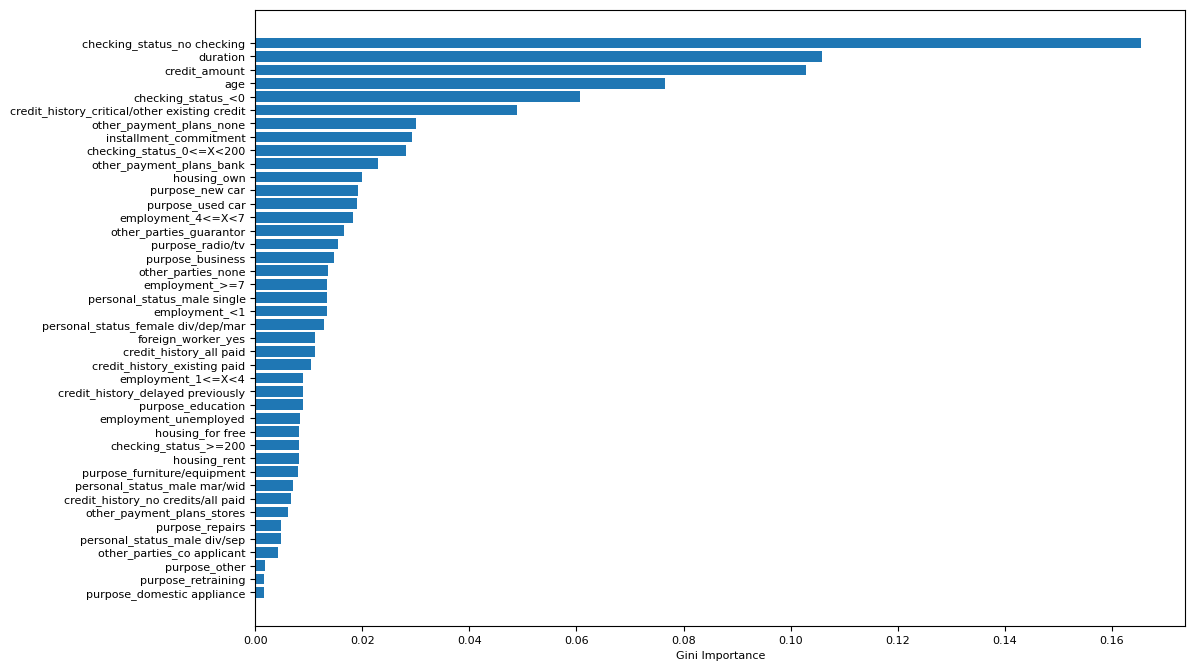

In [12]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 8})

order = clf.feature_importances_.argsort()
plt.barh(X_prime.columns[order], clf.feature_importances_[order])
plt.xlabel("Gini Importance");

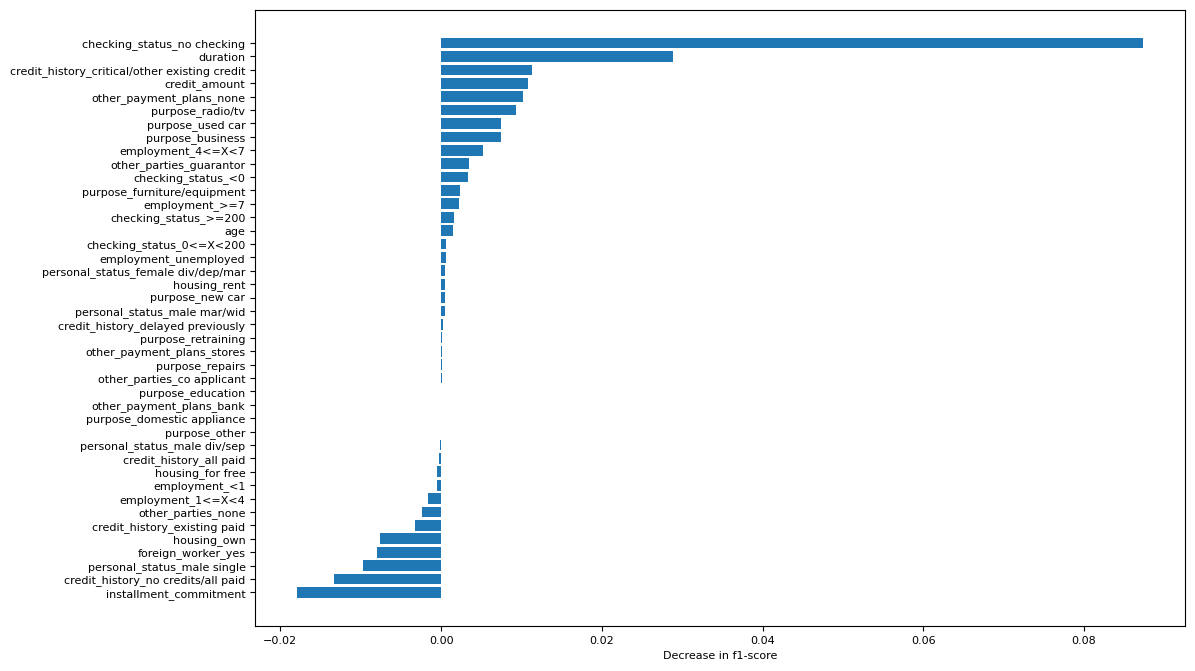

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# Permutation feature importance scores for each feature
X_train, X_test, y_train, y_test = train_test_split(X_prime, y, test_size=.3, random_state=random_state, stratify=y)
w_train, w_test = sample_weights[y_train.index], sample_weights[y_test.index]

clf = RandomForestClassifier(max_depth=7, random_state=random_state).fit(X_train, y_train, sample_weight=w_train)

# Optimize for n_repeats
# n_repeats = 0
# prev_importance = np.zeros(X_prime.shape[1])
# importance = np.ones(X_prime.shape[1])
# 
# while (np.abs(importance - prev_importance) > .001).any():
#     n_repeats += 10
#     prev_importance = importance
#     
#     perm_importance = permutation_importance(clf, X_test, y_test, scoring="f1", n_repeats=n_repeats, random_state=random_state, sample_weight=w_test)
#     importance = perm_importance.importances_mean

perm_importance = permutation_importance(clf, X_test, y_test, scoring="f1", n_repeats=60, random_state=random_state, sample_weight=w_test)

# Show the permutation feature importance scores on the bar graph
order = perm_importance.importances_mean.argsort()
plt.barh(X_prime.columns[order], perm_importance.importances_mean[order])
plt.xlabel("Decrease in f1-score");